In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 75kB/s 
     |████████████████████████████████| 450kB 33.7MB/s 
     |████████████████████████████████| 3.8MB 38.6MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
pip install tensorflow as tf

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(tf.__version__)

2.0.0


In [0]:
downloaded_content = drive.CreateFile({'id':'1Ygy467bUOlwl01YM0FhlQUd-hY-qDnGw'}) # replace the id with id of file you want to access
downloaded_content.GetContentFile('content.jpg') 

In [0]:
downloaded_style = drive.CreateFile({'id':'1ceVGi4YAbmw4pk1q_hvIxD1_Wpg4epWI'}) # replace the id with id of file you want to access
downloaded_style.GetContentFile('style_img.jpg') 

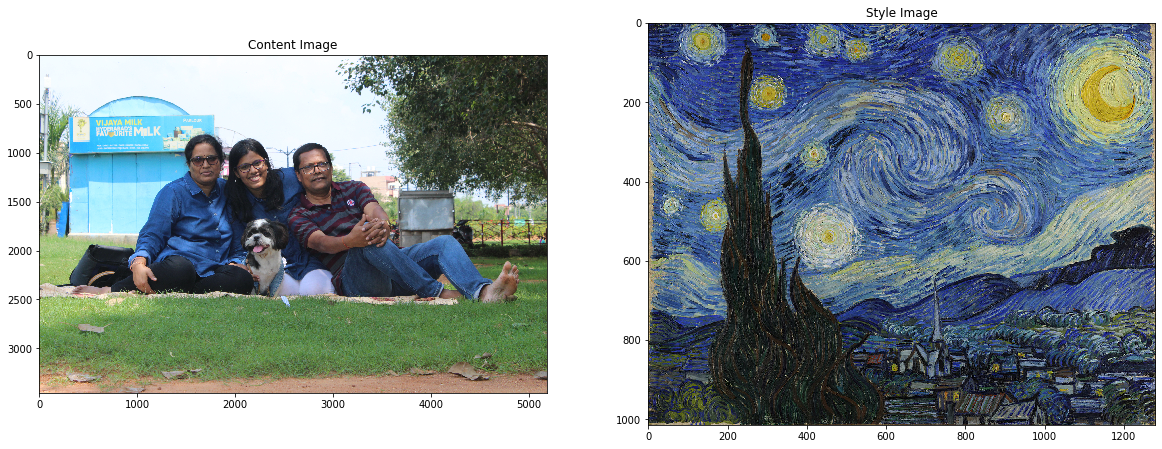

In [0]:
# Loading the content and style images
content = plt.imread('content.jpg')
style = plt.imread('style_img.jpg')

# Displaying the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Juxtaposing the Content and style images 
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

In [0]:
def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

In [0]:
# Using load_image to lead the content and style images
content = load_image('content.jpg')
style = load_image('style_img.jpg')

# Verifying the shapes
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [0]:
# Printing the names of the layers
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def mini_model(layer_names, model):

  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model

In [0]:
# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [0]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  


  def call(self, inputs):
    # Scaling back the pixel values
    inputs = inputs*255.0
    # Preprocessing them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Passing them through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregating the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    

    # Calculating the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assigning the content representation and gram matrix in a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [0]:
# The content and style images have been loaded into the content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02)

In [0]:
# Assigning custom weights to the style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

In [0]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extracting the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determining the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Updating the pixels
  opt.apply_gradients([(grad, image)])
  # Clipping the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [0]:
target_image = tf.Variable(content)

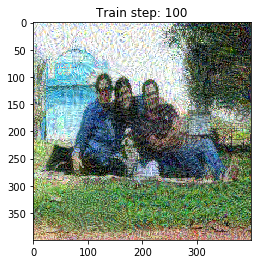

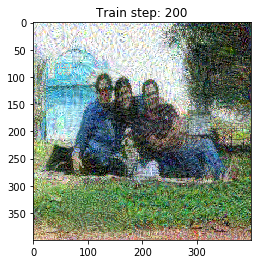

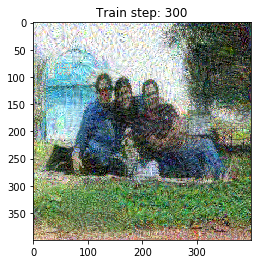

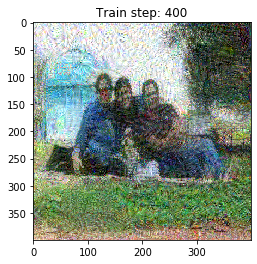

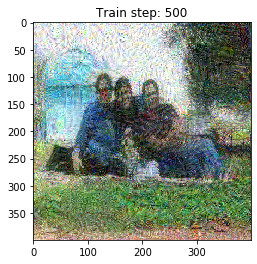

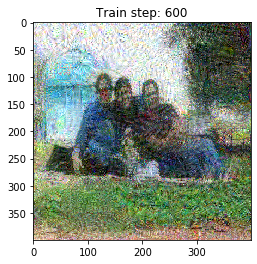

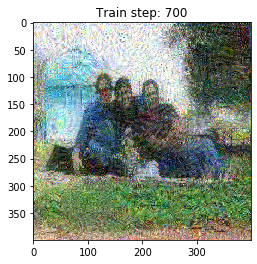

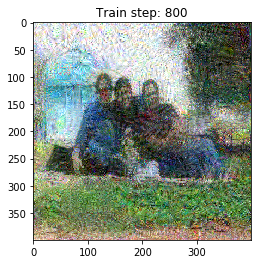

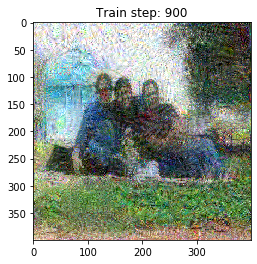

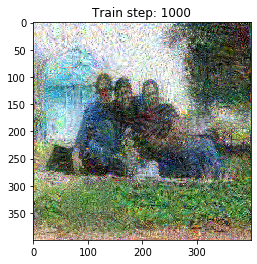

In [0]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()